## Predicting Y Vectors vs True Vectors

### July 3, 2018

### Marisa 

### Predicts an y vector from a pack using a given autoencoder and then puts both the true and predicted in a y vector in CSVs

In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy
import seaborn as sns
import networkx as nx
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Import Data

In [2]:
filePath = '/Users/marisa/test12/practice/reality/reality.csv'
df_initial = pd.read_csv(filePath)

In [3]:
df = df_initial.drop('End', axis=1)
nodes = max(max(df['Source'].unique()), max(df['Target'].unique()))
df.head()

Source  Target  Edge  Start
0       1       2     1      0
1      13       6     1      0
2      14      15     1      0
3       7      16     1      0
4       7      17     1      0

In [4]:
df.iloc[-1]

Source          15
Target          11
Edge             1
Start     20070600
Name: 1086403, dtype: int64

## Creating Vectors -> old functions
### Copied from reality functions

In [5]:
def create_vector(timerange, dataframe, nodes):
    '''
    create_vector

    requires: tuple timerange, data datframe, int nodes
    modifies: nothing
    effects: Creates a vector of size (nodes squared - nodes) / 2 out of dataframe in timerange
      Essentially taking data and making adjacency matrix in one dimension vector
    '''

    #x is the vector to be created & global so it can be changed by update_matrix 
    global x
    x = np.zeros((int((nodes ** 2 - nodes) / 2),))

    y = deepcopy(dataframe)

    #data_create_vector dataframe restricted to the data in the correct timerange
    data_create_vector = y.loc[(y['Start'] >= timerange[0]) & (y['Start'] <= timerange[1])]

    #iterates through data_create_vector with function update_matrix to finish vector
    data_create_vector.apply(update_matrix, axis=1)

    return x


In [6]:
def get_adj_time_range(timerange, dataframe, nodes):

    '''
    get_adj_time_range
    (originally from infectious data)

    requires: tuple timerange, dataframe, int nodes
    modifies: nothing
    effects: creates an adjacency matrix given a timeframe for a dataframe.
    Important for finding the eigenvector centrality
    '''
    df_copy = deepcopy(dataframe)

    #take slice of dataframe based on time
    dataframe_slice = df_copy.loc[(dataframe['Start'] >= timerange[0]) & (df_copy['Start'] <= timerange[1])]

    x = np.zeros((nodes, nodes))

    #fill adj. matrix
    for i, j in zip(dataframe_slice['Source'], dataframe_slice['Target']):
        x[int(i - 1)][int(j - 1)] += 1
        x[int(j -1)][int(i - 1)] += 1
    
    return x


In [7]:
def update_matrix(source_target_pair):
    '''
    update_matrix

    requires: tuple? source_target_pair
    modifies: x
    effects: adds a 1 to the right spot in x
    '''
    #source has index 0, target has index 1

    set_ = (source_target_pair[0], source_target_pair[1])

    #reset gets the indices in order and accounts for an off by one error
    reset = (min(set_) - 1, max(set_) - 1)

    #index is actually where we want to add the one in the 1D vector
    index = nodes * (reset[0]) - reset[0] * (1 + reset[0]) / 2 + (reset[1] - reset[0] - 1)


    x[int(index)] += 1



In [103]:
def training_data(dataframe_train, time_step, matrix_width, sample_size):
    '''
    training_data
    requires: dataframe_train w Source, Start, Target columns, int time_step, int matrix_width, 
    int sample_size
    modifes: nothing
    effects: puts vectors in training set and validation set
     NOTE: same as training_data_generator but not a generator
     UPDATED: in predicting y vectors no longer same as in reality functions
    '''
    X_train = []
    Y_train = []
    max_time = max(dataframe_train['Start'])
    time = 0

    #df_new is adjusted for time bounds
    df_new = dataframe_train.loc[dataframe_train['Start'] <= (max_time - time_step * (matrix_width + 1))]
  
    #total number of nodes
    nodes = max(max(dataframe_train['Source'].unique()), max(dataframe_train['Target'].unique()))
 
    #list of random indices that can be used to make new packs, of length sample_size
    #index length is changed to be 1 
    index_list = np.rint(np.random.uniform(low=0, high=(len(df_new) - 1), size=sample_size))
  

    for i in index_list:

        #the start time for the first edge (which has index i)
        time = df_new['Start'].iloc[int(i)]
        x_batch = []
        #Updated to keep track of where the vector starts
        i = 181483
        print('This is the starting point for x')
        print(i)
        print('\n')
       
        
        #this loop iterates through and creates a pack for training
        for j in range(matrix_width + 1):
            #the if statement sets aside one y vector at the end of every packl
            if j == (matrix_width):
                y_batch = create_vector((time + j * time_step, time + (j + 1) * time_step),
                 dataframe_train, nodes)
            else:
                x_batch.append(create_vector((time + j * time_step, time + (j + 1) * time_step),
                 dataframe_train, nodes))
    
        #add batches to training data
        X_train.append(x_batch)
        Y_train.append(y_batch)
    
    return (np.asarray(X_train), np.asarray(Y_train), time)


## Functions Created for Testing Vectors

In [104]:
'''
Prints all the nonzero vectors for a given vector of length len
'''
def print_nonzero(y, len):
    for i in range(0, len):
        if(y[0][i] != 0):
            #prints index of nonzero value
            print(i)
            #then prints nonzero value
            print(y[0][i])

In [95]:
'''
change_zeros
changes all nonzero values to zero based for a vector of 
    length size
'''
def change_zeros(v, size):
    x = np.zeros((1, size))
    for i in range(size):
        if (v[0][i] < 0):
            x[0][i] = 0
        else:
            x[0][i] = v[0][i]
    return x

In [96]:
'''
count_nonzeros
returns the number of nonzero values in vector v of 
    length size
'''
def count_nonzeros(v, size):
    count = 0
    for i in range(size):
        if(v[0][i] != 0):
            count += 1
    return count

## Metrics
#### Required for using the autoencoder model

In [97]:
def total_acc(y_pred, y_true):
    '''

    :param y_pred:
    :param y_true:
    :return: Total accuracy of the network, this includes zeros
    '''
    y_pred_int = tf.cast(tf.round(y_pred), dtype='int32')
    y_true_int = tf.cast(y_true, dtype='int32')

    bool_mat = tf.equal(y_pred_int, y_true_int)
    total_correct = tf.cast(tf.reduce_sum(tf.cast(bool_mat, dtype='float32')), dtype='int32')
    total = tf.cast(tf.shape(y_pred_int)[0] * tf.shape(y_pred_int)[1], dtype='int32')

    return (tf.divide(total_correct, total))


def y_true_non_zero(y_pred, y_true):
    '''

    :param y_pred:
    :param y_true:
    :return: Accuracy of the model on non-zero entries
    '''

    # Cast to integers
    y_pred_int = tf.cast(tf.round(y_pred), dtype='int32')
    y_true_int = tf.cast(y_true, dtype='int32')

    # Find the indices where tenor is not zero
    mat_index = tf.not_equal(y_true_int, 0)
    y_pred_sub = tf.boolean_mask(y_pred_int, mat_index)
    y_true_sub = tf.boolean_mask(y_true_int, mat_index)

    bool_mat = tf.equal(y_pred_sub, y_true_sub)
    total_correct = tf.cast(tf.reduce_sum(tf.cast(bool_mat, dtype='float32')), dtype='int32')

    total = tf.cast(tf.size(y_pred_sub), 'int32')

    return (tf.divide(total_correct, total))


def non_zero(y_pred, y_true):
    y_pred_int = tf.cast(tf.round(y_pred), dtype='int32')

    # There should not be a reason to round the true
    # But we do for the sake of symmetry
    y_true_int = tf.cast(tf.round(y_true), dtype='int32')

    logic_1 = tf.not_equal(y_pred_int, 0)
    logic_2 = tf.not_equal(y_true_int, 0)

    zero_index = tf.logical_or(logic_1, logic_2)

    y_pred_sub = tf.boolean_mask(y_pred_int, zero_index)
    y_true_sub = tf.boolean_mask(y_true_int, zero_index)

    bool_mat = tf.equal(y_pred_sub, y_true_sub)
    total_correct = tf.cast(tf.reduce_sum(tf.cast(bool_mat, dtype='int32')), dtype='int32')

    # It does not matter which sub vector is chosen
    total = tf.cast(tf.size(y_pred_sub), dtype='int32')

    return (tf.divide(total_correct, total))

def closeness_non_zero(y_pred, y_true):
    '''
    closeness_non_zero
    :param y_pred:
    :param y_true:
    :return: calculates how off the non_zero values are by only subtracting a percentage for
        every unit it is off

    '''
    #Percentage to take off for each integer wrong
    per_off = 0.25

    # There should not be a reason to round the true
    # But we do for the sake of symmetry
    y_true_int = tf.cast(tf.round(y_true), dtype='int32')
    y_pred_int = tf.cast(tf.round(y_pred), dtype='int32')

    #logic_1 is the nonzero mask for y_pred, and logic_2 is the same for y_true
    logic_1 = tf.not_equal(y_pred_int, 0)
    logic_2 = tf.not_equal(y_true_int, 0)

    zero_index = tf.logical_or(logic_1, logic_2)

    y_pred_sub = tf.boolean_mask(y_pred_int, zero_index)
    y_true_sub = tf.boolean_mask(y_true_int, zero_index)

    # Applies a relu on the subtracted tensor
    reduced_tens = tf.abs( tf.subtract(y_pred_sub, y_true_sub))

    #counts the number of zeros
    correct = tf.reduce_sum(tf.cast(tf.equal(reduced_tens, 0), dtype='int32'))

    # Closeness
    close_vec = tf.boolean_mask(reduced_tens, tf.not_equal(reduced_tens, 0))
    ones = tf.ones([tf.size(close_vec)])

    mult = tf.scalar_mul(per_off, tf.cast(close_vec, dtype='float32'))
    sub = tf.subtract(ones, mult)
    maxim = tf.maximum(tf.zeros(tf.shape(sub)), sub)
    close = tf.reduce_sum(maxim)

    #Find score
    score = tf.add(close, tf.cast(correct, dtype='float32'))

    #Return percentage of score / total
    total = tf.cast(tf.size(y_true_sub), dtype='float32')

    return tf.divide(score, total)



### Creating Vectors from data

In [105]:
m_width = 5
t_step = 200
size = 1
start_time = 0

x_vec, y_vec, start_time = training_data(df, t_step, m_width, size)
print(start_time)

This is the starting point for x
181483


14070600


## Loading Model & Predicting Vector

In [84]:
from keras.models import load_model

In [85]:
model = load_model('auto_adadelta_mse_(2280, 1140, 2280)_time_valS_True.h5', 
                   custom_objects={'total_acc': total_acc, 'y_true_non_zero': y_true_non_zero,
                    'non_zero': non_zero, 'closeness_non_zero': closeness_non_zero})

In [99]:
y_pred = model.predict(x_vec)

## Cleaning up Predicted Y Vector

In [100]:
y_pred = np.round_(y_pred, 0)

print(count_nonzeros(y_pred, 4560))

96


In [101]:
print(count_nonzeros(y_vec, 4560))

48


In [102]:
#get rid of negative numbers 
y_pred = change_zeros(y_pred, 4560)
print(count_nonzeros(y_pred, 4560))

72


### Changing Vector to Matrix Functions

In [82]:
'''
Requires: vector of upper diagonal adjaceny matrix, int nodes
Modifies: nothing
Effects: Takes a vector of size nodes squared - nodes and recreates an adjacency
  matrix from it

'''
def vec_to_adj(vector, nodes):
    count = 0
    matrix = np.zeros((nodes, nodes))
  
    #only need to iterate through top triangle
    for i in range(0, nodes-1):
        for j in range(i + 1 , nodes-1):
    
            matrix[i][j] = vector[0][count]
            matrix[j][i] = vector[0][count]
            count += 1
      
    return matrix

In [55]:
'''
find_next_nonz
Finds the next nonzero value in the given matrix and 
    returns the index
The starty value must always be one past a current nonzero
   
I.E. If there is a nonzero at 12, 3, pass startx in as 12
    but starty in as 4
'''
def find_next_nonz(startx , starty, matrix, size):
    #finish going through the given row of value
    
    for j in range(starty, size):
            if(matrix[startx][j] != 0):
                return startx, j

    for i in range(startx + 1, size):
        for j in range(0, size):
            if(matrix[i][j] != 0):
                return i, j
            
    #This is just in case return statement, should never run
    return -1, -1

In [56]:
def count_pos_matrix(matrix, size):
    pos = 0
    for i in range(size):
        for j in range(size):

            if (matrix[i][j] > 0):
                pos += 1
    return pos

In [57]:
def count_neg_matrix(matrix, size):
    neg = 0
    for i in range(size):
        for j in range(size):

            if (matrix[i][j] < 0):
                neg += 1
    return neg

In [58]:
def count_nonzero_matrix(matrix, size):
    nz = 0
    for i in range(size):
        for j in range(size):

            if (matrix[i][j] != 0):
                nz += 1
    return nz

### Actually Changing the Vectors to Adj. Matrices
#### Run this

In [59]:
#Use old method to change to adjacency matrix
y_pred_matrix = vec_to_adj(y_pred, 96)
y_matrix = vec_to_adj(y_vec, 96)

In [60]:
#should be double of nonzeros in vector
print('predicted nonzeros in matrix: ', count_nonzero_matrix(y_pred_matrix, 96))

predicted nonzeros in matrix:  2


In [61]:
print('nonzeros in true y matrix: ', count_nonzero_matrix(y_matrix, 96))

nonzeros in true y matrix:  6


## Attempt 2 on Getting CSVs

In [62]:
def reformat(old_mat, num_nonz, nodes):
    new_mat = np.zeros((nodes + num_nonz, 3))
    
    curX = 0
    curY = 0
    
    #adds in the right numbers in the table to make a df
    for i in range(num_nonz):
        curX, curY = find_next_nonz(curX , curY , old_mat, 96)
        new_mat[i][0] = curX
        new_mat[i][1] = curY
        new_mat[i][2] = old_mat[curX][curY]
        curY += 1
    new_mat = add_nodes(new_mat, num_nonz, nodes)
    return new_mat

In [63]:
def add_nodes(mat, nonzero, nodes):
    #adds in rest of the nods for gephi
    for i in range(0,  nodes):
        mat[i + nonzero][0] = i 
        mat[i + nonzero][1] = i
        mat[i + nonzero][2] = 0.2
    return mat

#### Y Predicted You First- putting in reformatted numpy

In [64]:
nonz_pred = count_nonzero_matrix(y_pred_matrix, 96)
reformat_pred = reformat(y_pred_matrix, nonz_pred, 96)

### Same thing w y_true

In [65]:
nonz_true = count_nonzero_matrix(y_matrix, 96)
reformat_true = reformat(y_matrix, nonz_true, 96)

## Stick it in the old df

In [66]:
df_pred = pd.DataFrame(reformat_pred, columns = ['Source', 'Target', 'Weight'])
df_pred.head()

Source  Target  Weight
0    10.0    24.0     1.0
1    24.0    10.0     1.0
2     0.0     0.0     0.2
3     1.0     1.0     0.2
4     2.0     2.0     0.2

In [67]:
df_true = pd.DataFrame(reformat_true, columns = ['Source', 'Target', 'Weight'])
df_true.head()

Source  Target  Weight
0     9.0    22.0     2.0
1    13.0    27.0     2.0
2    22.0     9.0     2.0
3    27.0    13.0     2.0
4    74.0    81.0     6.0

### Saving to CSV!

In [40]:
df_pred.to_csv("pred_edgelist2.csv", index = False)
df_true.to_csv("true_edgelist2.csv", index = False)

### BONUS SECTION: Reformatting Matrices and Putting in Graphs

In [68]:
#pred_np = np.zeros((3, 30))

In [69]:
g_pred = nx.from_numpy_matrix(y_pred_matrix)
g_true = nx.from_numpy_matrix(y_matrix)

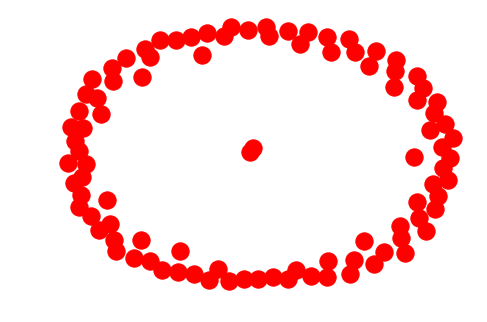

In [70]:
nx.draw(g_pred)

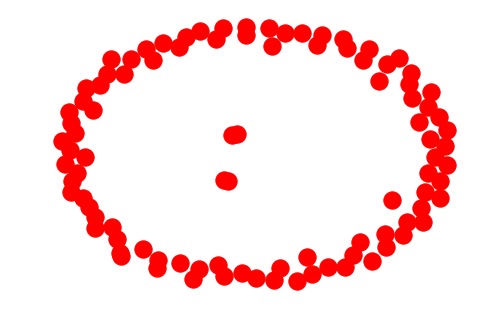

In [71]:
nx.draw(g_true)

In [72]:
g_pred.edges()

EdgeView([(10, 24)])

In [73]:
g_true.edges()

EdgeView([(9, 22), (13, 27), (74, 81)])